In [4]:
# imports
# Generic
import os
import json
from pathlib import Path
import typing
import html

# Plotting
import plotly.io as pio
pio.renderers.default = "notebook_connected" # Specify plotly renderer for vscode
import matplotlib.pyplot as plt
import IPython
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Numerical Computing
import numpy as np
import torch
import pandas as pd

# Transformer Stuff
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

# Utilities
from muutils.logger import Logger, TimerContext
from muutils.json_serialize import json_serialize, dataclass_serializer_factory
from muutils.tensor_utils import ATensor, NDArray
from muutils.statcounter import StatCounter
from muutils.misc import shorten_numerical_to_str

# Our Code
from maze_transformer.generation.latticemaze import LatticeMaze
from maze_transformer.generation.generators import LatticeMazeGenerators
from maze_transformer.training.tokenizer import MazeTokenizer, SPECIAL_TOKENS
from maze_transformer.training.mazedataset import MazeDatasetConfig, MazeDataset
from maze_transformer.evaluation.plot_maze import plot_multi_paths, PathFormat
from maze_transformer.training.dataset import GPTDatasetConfig
from maze_transformer.training.config import TrainConfig
from maze_transformer.training.training import TRAIN_SAVE_FILES
from maze_transformer.evaluation.eval_model import generate_plot_predicted_path, MazePath, load_model_with_configs, predict_maze_path
from maze_transformer.evaluation.pathdist import MazeEvalFunction, ArrMazeEvalFunction, MazeEvalFuncs, ArrMazeEvalFuncs
from maze_transformer.evaluation.eval_model import decode_maze_tokens_to_coords, predict_tokens, pad_sequence
from maze_transformer.evaluation.plot_attention import colorize

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# -- Configuration --
# We won't be training any models
torch.set_grad_enabled(False) 

# Set seed for reproducibility
seed = 42
_= torch.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DARK_MODE = True
if DARK_MODE:
    pio.templates.default = "plotly_dark"
    plt.style.use("dark_background")

In [10]:
# load model and configs
maze_dataset = "../data/maze/debug_maze"
# Get latest model
model_path = list(sorted(Path(maze_dataset).glob('**/model.final.pt'), key=os.path.getmtime))[-1].resolve()
model, cfg = load_model_with_configs(model_path)

In [11]:
# generate a maze
grid_n: int = cfg.dataset_cfg.grid_n
maze: LatticeMaze = LatticeMazeGenerators.gen_dfs((grid_n, grid_n))
c_start = (0, 0)
c_end = (grid_n - 1, grid_n - 1)

# solve the maze explicitly
path_true = np.array(maze.find_shortest_path(
	c_start = c_start,
	c_end = c_end,
))

solved_maze: MazeTokenizer = MazeTokenizer(
	maze=maze,
	solution=np.array(maze.find_shortest_path(
		c_start=c_start,
		c_end=c_end,
	)),
)

# tokenize the maze
maze_only_tokens: list[str] = solved_maze.as_tokens(cfg.dataset_cfg.node_token_map , solution = False) + [ SPECIAL_TOKENS["start_path"] ]

print("maze tokens:", maze_only_tokens)

array_nopad = torch.tensor(
	[ cfg.dataset_cfg.tokenizer_map[t] for t in maze_only_tokens ], 
	dtype=torch.int32,
	device="cpu",
)
array = array_nopad
# print(model.to_tokens(maze_only_tokens))
# array: torch.Tensor = pad_sequence(array_nopad, cfg)

maze tokens: ['<ADJLIST_START>', '(1,1)', '<-->', '(2,1)', ';', '(0,1)', '<-->', '(0,0)', ';', '(1,3)', '<-->', '(1,2)', ';', '(3,0)', '<-->', '(2,0)', ';', '(2,1)', '<-->', '(3,1)', ';', '(0,1)', '<-->', '(0,2)', ';', '(1,3)', '<-->', '(2,3)', ';', '(1,0)', '<-->', '(0,0)', ';', '(3,2)', '<-->', '(2,2)', ';', '(0,3)', '<-->', '(0,2)', ';', '(1,2)', '<-->', '(1,1)', ';', '(1,3)', '<-->', '(0,3)', ';', '(2,3)', '<-->', '(3,3)', ';', '(3,2)', '<-->', '(3,3)', ';', '(2,0)', '<-->', '(1,0)', ';', '<ADJLIST_END>', '<TARGET_START>', '(3,3)', '<TARGET_END>', '<START_PATH>']


In [12]:
# have the model predict some tokens
context_str: list[str] = maze_only_tokens

# escape for html
context_str = [ html.escape(t) for t in context_str ]

array_tensor = torch.tensor(array).long().unsqueeze(0).to(device)
with torch.no_grad():
	logits, cache = model.run_with_cache(array_tensor)

attentions = [w for k, w in cache.items() if 'hook_pattern' in k]
print(f"{logits.shape = }\n{len(attentions) = }\n{[x.shape for x in attentions] = }")

# `output.attentions` is a tuple of tensors, where each element of the tuple corresponds to a layer. 
#  The tensor has dimensions (1, n_heads, n_positions, n_positions)


logits.shape = torch.Size([1, 66, 25])
len(attentions) = 4
[x.shape for x in attentions] = [torch.Size([1, 2, 66, 66]), torch.Size([1, 2, 66, 66]), torch.Size([1, 2, 66, 66]), torch.Size([1, 2, 66, 66])]


/var/folders/7r/mxsffy3s1xn40wbtsc3zr6680000gn/T/ipykernel_32374/2563559741.py:7: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [13]:
from circuitsvis.attention import attention_heads
n_layers: int = len(attentions)
n_heads: int = attentions[0].shape[1]
n_tokens: int = attentions[0].shape[2]
attention_to_plot = torch.concatenate(attentions, dim=0).reshape(-1, n_tokens, n_tokens)
attention_head_names = [f"Layer {i} Head {j}" for i in range(n_layers) for j in range(n_heads)]
attention_heads(attention_to_plot,maze_only_tokens, attention_head_names)

ModuleNotFoundError: No module named 'circuitsvis'

In [14]:
from circuitsvis.tokens import colored_tokens_multi
#! ALEX note - there used to be a np.power(head_np, 1/4) here, not sure what that's about?
FROM_TOKEN = -1 # Look at attention from this token position to the rest of the sequence
attentions_from_token = torch.concatenate([w[0, :, FROM_TOKEN, :] for w in attentions], dim=0)
colored_tokens_multi(context_str, attentions_from_token.T, labels=attention_head_names)

ModuleNotFoundError: No module named 'circuitsvis'

  0%|          | 0/50 [00:00<?, ?it/s]

(4, 4)


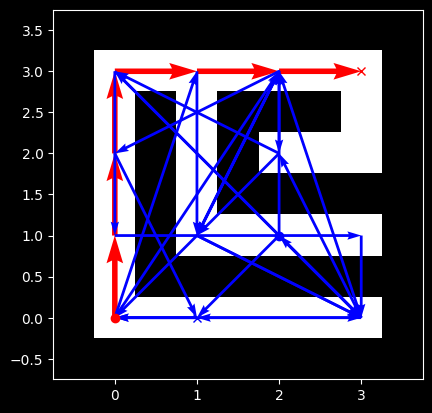

In [15]:
eos_id = cfg.dataset_cfg.tokenizer_map[SPECIAL_TOKENS["end_path"]]
predictions = model.generate(array_tensor, max_new_tokens=50, 
                        	eos_token_id=eos_id, stop_at_eos=True)
#! TODO stop_eos to True once wrapped tokenizer is in the HookedTransformer

# decode the tokens
predicted_tokens = [ cfg.dataset_cfg.token_arr[t] for t in predictions[0] ]

path_predicted: list[tuple[int,int]] = decode_maze_tokens_to_coords(
	predicted_tokens[len(maze_only_tokens):],
	mazedata_cfg = cfg.dataset_cfg, 
	when_noncoord = "skip",
)

# plot the maze and both solutions
# for label, fmt, color, path in paths
plot_multi_paths(
	maze = maze,
	paths = [
		PathFormat(path_true, "true", "-", "red", {'width': 0.015}),
		PathFormat(np.array(path_predicted), "predicted", ":", "blue", {}),
	],
)